# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [15]:
# Import necessary libraries
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score

# from sklearn.metrics import accuracy_score, mean_squared_error

# Import chosen baseline model
from sklearn.linear_model import LogisticRegression

# configuration
input_folder = "temp_processed_images"                  # folder with preprocessed imagefiles
categories = ["with_seamount", "without_seamount"]      # Subfolders in `image_folder` with catgeories

## Model Choice

In order to reduce complexity as much as possible, we have opted for your LogisticRegression model. The model is provided by the sklearn framework as an implementation and can process image data. 

The image data must first be converted to vector format and the image colour values must be normalized to values between 0..1.


## Feature Selection

Since the goal of the project is binary classification and we are working with image data as input, we worked with all features as input, but reduced the image data to a size of 128x128 pixels and did not apply any special convolution or pooling.

In this step we 
- Read-in the files
- split in test, validation and trainingsdata sets
- undersample traingsdata
- normalize data in all sets


In [23]:
# determine the sample imagesize by picking on sample image out of folders
def get_first_image_size(input_folder, categories):
    for category in categories:
        category_folder = os.path.join(input_folder, category)
        if os.path.exists(category_folder) and os.path.isdir(category_folder):
            # Liste der Dateien im Ordner
            for file_name in os.listdir(category_folder):
                file_path = os.path.join(category_folder, file_name)
                if os.path.isfile(file_path):  # Stelle sicher, dass es eine Datei ist
                    image = cv2.imread(file_path)
                    if image is not None:
                        # Rückgabe der Bildgröße (Höhe, Breite)
                        return image.shape[0], image.shape[1]  # Höhe und Breite
    return None, None  # if non image found

image_size = [0, 0]
image_size[0], image_size[1] = get_first_image_size(input_folder, categories)

print(f"Imagesample size of {image_size[0]}x{image_size[1]}Pixel size!\n")

# Load processed dataset
def load_data(directory, categories):
    data, labels = [], []
    category_counts = {} 
    for label, category in enumerate(categories):
        category_folder = os.path.join(directory, category)
        file_count = 0
        for file_name in os.listdir(category_folder):
            file_path = os.path.join(category_folder, file_name)
            image = cv2.imread(file_path)
            if image is not None:
                data.append(image.flatten())  # Flatten to vector for regression
                labels.append(label)
                file_count += 1
        category_counts[category] = file_count
    return np.array(data), np.array(labels), category_counts

data, labels, category_counts = load_data(input_folder, categories)

print("Number of samples per category:")
for category, count in category_counts.items():
    print(f"Category '{category}': {count} images")

# function for balancing by undersampling
def balance_classes_undersample(X, y):
    unique_classes = np.unique(y)
    min_count = min([np.sum(y == cls) for cls in unique_classes])  # Kleinste Anzahl pro Klasse
    X_balanced, y_balanced = [], []
    
    for cls in unique_classes:
        X_cls = X[y == cls]
        y_cls = y[y == cls]
        
        # Undersample die Klasse auf die minimale Anzahl
        X_undersampled, y_undersampled = resample(
            X_cls, y_cls, 
            replace=False,  # Kein Ersatz
            n_samples=min_count, 
            random_state=42
        )
        X_balanced.append(X_undersampled)
        y_balanced.append(y_undersampled)
    
    # Verbinde die Klassen wieder zu einem Array
    return np.vstack(X_balanced), np.hstack(y_balanced)


# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print count of samples per class in traingsdata
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print("\nCount of samples per class in traingsdata before undersampling:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} Samplecount")

# Undersampling only needed on trainingsdata
X_train, y_train = balance_classes_undersample(X_train, y_train)

unique_classes, class_counts = np.unique(y_train, return_counts=True)
print("Count of samples per class in traingsdata after undersampling:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} Samplecount")

# Normalize pixel values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



Imagesample size of 128x128Pixel size!

Number of samples per category:
Category 'with_seamount': 2559 images
Category 'without_seamount': 1000 images

Count of samples per class in traingsdata before undersampling:
Class 0: 1789 Samplecount
Class 1: 702 Samplecount
Count of samples per class in traingsdata after undersampling:
Class 0: 702 Samplecount
Class 1: 702 Samplecount


## Implementation

[Implement your baseline model here.]



In [10]:
# Train logistic regression model
print("Training Logistic Regression Model...")
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train, y_train)

Training Logistic Regression Model...


LogisticRegression(max_iter=1000, random_state=42)

## Evaluation

The code evaluates the model's performance using the following metrics:

**Classification Report**: Includes precision, recall, F1-score, and support for each class, providing a comprehensive view of the model's performance across the validation and test datasets.

**Accuracy Score**: Calculates the overall percentage of correctly classified samples for both validation and test sets.

**Visualization of Predictions**: Randomly selects and displays test images with their true and predicted labels, offering qualitative insights into the model's classification behavior.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.29667132236580107..1.258547246087495].


Label Mapping in Training Data:
Label 0: with_seamount
Label 1: without_seamount

Validation Results:
                  precision    recall  f1-score   support

   with_seamount       0.99      0.86      0.92       378
without_seamount       0.74      0.97      0.84       156

        accuracy                           0.89       534
       macro avg       0.86      0.92      0.88       534
    weighted avg       0.92      0.89      0.90       534

Validation Accuracy: 0.8932584269662921

Test Results:
                  precision    recall  f1-score   support

   with_seamount       1.00      0.81      0.90       392
without_seamount       0.66      1.00      0.79       142

        accuracy                           0.86       534
       macro avg       0.83      0.91      0.84       534
    weighted avg       0.91      0.86      0.87       534

Test Accuracy: 0.8614232209737828

Visualizing Predictions on Test Set:


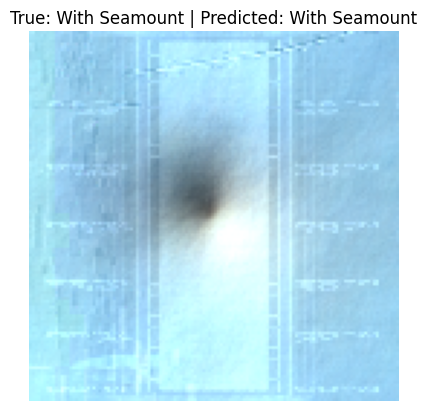

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.313237053143519..3.1966994051210142].


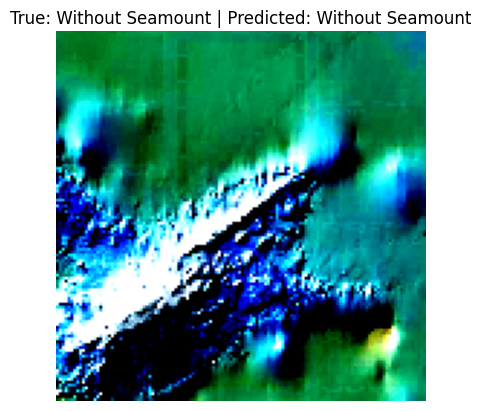

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.462857961300924..3.2551205980727924].


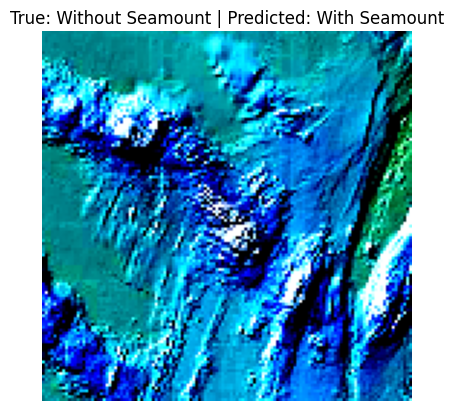

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.738841763700528..3.309555587537416].


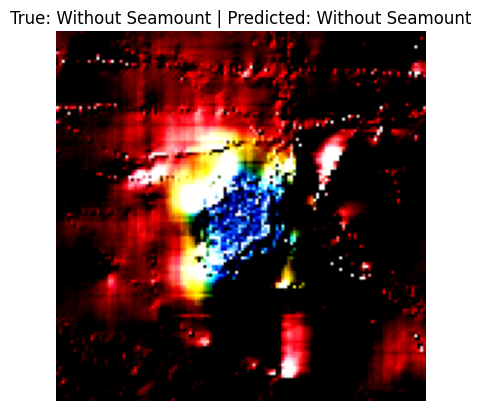

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.454892867662841..2.551344618700989].


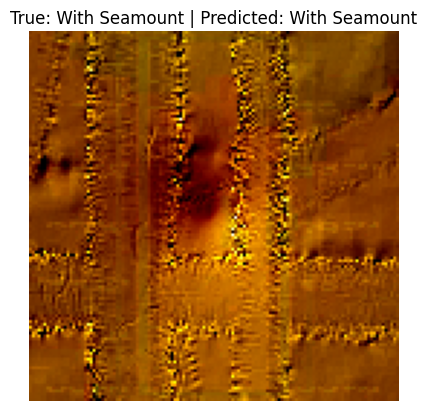

In [26]:
# show class mapping number to lable
unique_labels = np.unique(y_train)

print("Label Mapping in Training Data:")
for label in unique_labels:
    print(f"Label {label}: {categories[label]}")

# Evaluate model
y_val_pred = logistic_model.predict(X_val)
y_test_pred = logistic_model.predict(X_test)

print("\nValidation Results:")
print(classification_report(y_val, y_val_pred, target_names=categories))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

print("\nTest Results:")
print(classification_report(y_test, y_test_pred, target_names=categories))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

# Visualize a few test images with predictions
def visualize_predictions(X, y_true, y_pred, num_images=5):
    indices = np.random.choice(len(X), num_images, replace=False)
    for i in indices:
        img = X[i].reshape(image_size[0], image_size[1], 3)  # Reshape to original image dimensions
        true_label = "With Seamount" if y_true[i] == 1 else "Without Seamount"
        predicted_label = "With Seamount" if y_pred[i] == 1 else "Without Seamount"
        
        plt.figure()
        plt.imshow(img)
        plt.title(f"True: {true_label} | Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

print("\nVisualizing Predictions on Test Set:")
visualize_predictions(X_test, y_test, y_test_pred, num_images=5)
